# Building makemore - MLP

> This lecture note will mostly be following the https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf paper

In [ ]:
import numpy
import torch
import torch.nn.functional as F
from rich import print
from rich import pretty
import matplotlib.pyplot as plot
import random
%matplotlib inline

In [ ]:
pretty.install()

In [ ]:
g = torch.Generator().manual_seed(42)

## Read in all the words

In [ ]:
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

## Build the vocabulary of characters and mapping to/from integers

In [ ]:
chars = sorted(list(set(''.join(words))))

In [ ]:
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

In [ ]:
itos = {i:s for s, i in stoi.items()}

In [ ]:
itos

{
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z',
    0: '.'
}

## Build the training dataset

In [ ]:
block_size = 3

What is `block_size`?
> context length: how many characters do we take to predict the next one?

In [ ]:
def generate_training_set(words, block_size, print_disabled=False):
    X, Y = [], []
    for w in words:
        if print_disabled: print(w)
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if print_disabled: print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Generating training set for block size of 2

In [ ]:
X, Y = generate_training_set(words[:2], 2, True)

emma

.. ---> e

.e ---> m

em ---> m

mm ---> a

ma ---> .

olivia

.. ---> o

.o ---> l

ol ---> i

li ---> v

iv ---> i

vi ---> a

ia ---> .

### Generating training set for block size of 5

In [ ]:
X, Y = generate_training_set(words[:2], 5, True)

emma

..... ---> e

....e ---> m

...em ---> m

..emm ---> a

.emma ---> .

olivia

..... ---> o

....o ---> l

...ol ---> i

..oli ---> v

.oliv ---> i

olivi ---> a

livia ---> .

### Generate training set for block size of 3 
> as mentioned in the above paper

In [ ]:
X, Y = generate_training_set(words[:2], 3)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([12, 3]), torch.int64, torch.Size([12]), torch.int64)

## Embedding Lookup Table

In [ ]:
C = torch.randn((27, 2))

In [ ]:
C.dtype

torch.float32

In [ ]:
C

tensor([[ 0.0494, -0.0211],
        [ 0.6477, -0.5360],
        [-0.9756, -1.5765],
        [-0.0935, -0.5134],
        [-0.3660, -1.1029],
        [ 1.3134, -0.4618],
        [-0.9528,  0.0358],
        [ 0.5850,  0.0884],
        [-0.6457,  0.5524],
        [-0.5182,  0.1713],
        [-1.1681, -1.2686],
        [-0.2436, -0.2827],
        [ 1.7086,  0.4918],
        [-1.1856,  1.1905],
        [ 0.6216, -1.3340],
        [ 0.3233, -0.4307],
        [ 0.0207,  0.2296],
        [-1.4710,  0.0351],
        [-0.7824,  1.2608],
        [-0.6630,  0.0953],
        [-0.3874, -0.9611],
        [ 0.2068, -0.2570],
        [-1.0127, -1.0864],
        [-0.3755, -1.8281],
        [ 0.6910,  0.0300],
        [-0.2178, -1.1080],
        [-1.0800, -1.2573]])

### Indexing into the embedding

#### 1. Index with a number

In [ ]:
C[5]

tensor([ 1.3134, -0.4618])

#### 2. Multiplying with one-hot encoding

In [ ]:
one_hot_vec = F.one_hot(torch.tensor(5), num_classes=27).float()

Converted the above one into float so that it can be multiplied with `C`, which is a float

In [ ]:
one_hot_vec.shape

torch.Size([27])

In [ ]:
one_hot_vec @ C

tensor([ 1.3134, -0.4618])

As we can see the result is same as indexing with a number

In [ ]:
torch.equal(one_hot_vec @ C, C[5])

True

##### Lets explore indexing 

In [ ]:
C[torch.tensor([5, 6, 7, 7, 7, 7, 7])]

tensor([[ 1.3134, -0.4618],
        [-0.9528,  0.0358],
        [ 0.5850,  0.0884],
        [ 0.5850,  0.0884],
        [ 0.5850,  0.0884],
        [ 0.5850,  0.0884],
        [ 0.5850,  0.0884]])

In [ ]:
C[X]

tensor([[[ 0.0494, -0.0211],
         [ 0.0494, -0.0211],
         [ 0.0494, -0.0211]],

        [[ 0.0494, -0.0211],
         [ 0.0494, -0.0211],
         [ 1.3134, -0.4618]],

        [[ 0.0494, -0.0211],
         [ 1.3134, -0.4618],
         [-1.1856,  1.1905]],

        [[ 1.3134, -0.4618],
         [-1.1856,  1.1905],
         [-1.1856,  1.1905]],

        [[-1.1856,  1.1905],
         [-1.1856,  1.1905],
         [ 0.6477, -0.5360]],

        [[ 0.0494, -0.0211],
         [ 0.0494, -0.0211],
         [ 0.0494, -0.0211]],

        [[ 0.0494, -0.0211],
         [ 0.0494, -0.0211],
         [ 0.3233, -0.4307]],

        [[ 0.0494, -0.0211],
         [ 0.3233, -0.4307],
         [ 1.7086,  0.4918]],

        [[ 0.3233, -0.4307],
         [ 1.7086,  0.4918],
         [-0.5182,  0.1713]],

        [[ 1.7086,  0.4918],
         [-0.5182,  0.1713],
         [-1.0127, -1.0864]],

        [[-0.5182,  0.1713],
         [-1.0127, -1.0864],
         [-0.5182,  0.1713]],

        [[-1.0127, -1.0864],
         [-0.5182,  0.1713],
         [ 0.6477, -0.5360]]])

In [ ]:
C[X].shape

torch.Size([12, 3, 2])

In [ ]:
X[11, 2]

tensor(1)

In [ ]:
C[X][11, 2]

tensor([ 0.6477, -0.5360])

In [ ]:
C[1]

tensor([ 0.6477, -0.5360])

In [ ]:
torch.equal(C[X][11, 2], C[1])

True

## Hidden Layer

In [ ]:
emb = C[X]
emb.shape

torch.Size([12, 3, 2])

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

We have to flatten the last two dimensions of `emb` so that it can be multiplied with `W1`

In [ ]:
emb[:, 0, :].shape

torch.Size([12, 2])

### `torch.cat` and `torch.bind`

In [ ]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([12, 6])

In [ ]:
len(torch.unbind(emb, 1))

3

In [ ]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([12, 6])

The above one is insufficient and creates memory

### torch internal: storage, views

In [ ]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
a.shape

torch.Size([18])

In [ ]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [ ]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [ ]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [ ]:
a.storage()

0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [ ]:
emb.shape

torch.Size([12, 3, 2])

In [ ]:
emb.view(12, 6)

tensor([[ 0.0494, -0.0211,  0.0494, -0.0211,  0.0494, -0.0211],
        [ 0.0494, -0.0211,  0.0494, -0.0211,  1.3134, -0.4618],
        [ 0.0494, -0.0211,  1.3134, -0.4618, -1.1856,  1.1905],
        [ 1.3134, -0.4618, -1.1856,  1.1905, -1.1856,  1.1905],
        [-1.1856,  1.1905, -1.1856,  1.1905,  0.6477, -0.5360],
        [ 0.0494, -0.0211,  0.0494, -0.0211,  0.0494, -0.0211],
        [ 0.0494, -0.0211,  0.0494, -0.0211,  0.3233, -0.4307],
        [ 0.0494, -0.0211,  0.3233, -0.4307,  1.7086,  0.4918],
        [ 0.3233, -0.4307,  1.7086,  0.4918, -0.5182,  0.1713],
        [ 1.7086,  0.4918, -0.5182,  0.1713, -1.0127, -1.0864],
        [-0.5182,  0.1713, -1.0127, -1.0864, -0.5182,  0.1713],
        [-1.0127, -1.0864, -0.5182,  0.1713,  0.6477, -0.5360]])

In [ ]:
torch.equal(emb.view(12, 6), torch.cat(torch.unbind(emb, 1), 1))

True

#### Now lets multiply `emb` and `W1`

In [ ]:
h = emb.view(12, 6) @ W1 + b1
h.shape

torch.Size([12, 100])

In [ ]:
h = emb.view(emb.shape[0], 6) @ W1  + b1
h.shape

torch.Size([12, 100])

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h

tensor([[ 0.4915,  0.7098, -0.0430,  ...,  0.2994,  0.9402,  0.7398],
        [-0.6305,  0.6804, -0.4876,  ...,  0.9315,  0.9978,  0.9405],
        [ 1.0000,  0.9850, -0.0248,  ..., -0.6091, -0.5962,  0.8272],
        ...,
        [-0.9984,  0.0219,  0.4668,  ..., -0.9974,  0.9967,  0.8833],
        [ 0.2683, -0.9647, -0.9713,  ..., -0.4932, -0.9902,  0.7563],
        [-0.0409,  0.5042,  0.7568,  ...,  0.9979,  0.8698,  0.9306]])

In [ ]:
h.shape

torch.Size([12, 100])

#### Deconstruct the addition of `emb.view(-1, 6) @ W1` and `b1` : Broadcasting

In [ ]:
(emb.view(-1, 6) @ W1).shape

torch.Size([12, 100])

In [ ]:
b1.shape

torch.Size([100])

Broadcasting

- 12 by 100

- 1   by 100

Rowwise addition of `b1` to `(emb.view(-1, 6) @ W1)`

## Output Layer

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([12, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts/counts.sum(1, keepdims=True)

In [ ]:
prob.shape

torch.Size([12, 27])

In [ ]:
prob[0].sum()

tensor(1.)

In [ ]:
torch.arange(12)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0])

In [ ]:
prob[torch.arange(12), Y]

tensor([8.2187e-08, 1.1724e-01, 1.6640e-18, 1.7638e-02, 8.5638e-13, 3.6065e-03,
        1.6173e-08, 8.1841e-01, 3.2394e-06, 6.6904e-06, 1.5042e-07, 9.6335e-15])

In [ ]:
loss = -prob[torch.arange(12), Y].log().mean()
loss

tensor(15.6269)

## Summary of the Full Network

In [ ]:
X.shape, Y.shape

(torch.Size([12, 3]), torch.Size([12]))

In [ ]:
def initialize_params(hc):
    C = torch.randn((27, 2), generator=g)
    W1 = torch.randn((6, hc), generator=g)
    b1 = torch.randn(hc, generator=g)
    W2 = torch.randn((hc, 27), generator=g)
    b2 = torch.randn(27, generator=g)

    return [C, W1, b1, W2, b2]

In [ ]:
parameters = initialize_params(100)

In [ ]:
sum(p.nelement() for p in parameters)

3481

In [ ]:
def forward_pass(params, X):
    C, W1, b1, W2, b2 = params
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    return logits

In [ ]:
def calcualte_loss(logits, Y):
    counts = logits.exp()
    prob = counts/counts.sum(1, keepdims=True)
    return -prob[torch.arange(12), Y].log().mean()

In [ ]:
logits = forward_pass(parameters, X)

In [ ]:
calcualte_loss(logits, Y)

tensor(19.1366)

## Introducting F.cross_entropy and why?

In [ ]:
F.cross_entropy(logits, Y)

tensor(19.1366)

### why?

1. Pytorch does not create intermediate tensors for the following code
<code>
counts = logits.exp()
prob = counts/counts.sum(1, keepdims=True)
loss = -prob[torch.arange(12), Y].log().mean()
</code>
Instead it clusters up all the above operation and it efficiently computes 


2. Backward prop is efficient. Simple to implement


3. It can numerically well behaved

In [ ]:
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [ ]:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [ ]:
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

As we can see the negative numbers are ok, but positive numbers can overflow the exp

So pytorch internally offset the logits with maximum number

In [ ]:
logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

so better to call `F.cross_entropy(logits, Y)`

## Implementing the Training Loop, overfitting one batch

In [ ]:
for p in parameters: p.requires_grad = True 

In [ ]:
def backward_pass(params, loss, lr=0.1):
    for p in params:
        p.grad= None
    loss.backward()
    
    for p in params:
        p.data += - lr * p.grad
    return params, loss

In [ ]:
def an_epoch(parameters, X, Y, **args):
    logits = forward_pass(parameters, X)
    loss = F.cross_entropy(logits, Y)
    backward_pass(parameters, loss, **args)
    return loss

In [ ]:
for _ in range(10):
    loss = an_epoch(parameters, X, Y)
    print(loss.item())

19.136564254760742

13.381081581115723

9.38259220123291

6.92555570602417

4.83230447769165

3.4374144077301025

2.392893075942993

1.488807201385498

0.9096290469169617

0.6129968762397766

In [ ]:
logits = forward_pass(parameters, X); logits.max(1)

torch.return_types.max(
values=tensor([ 9.8012, 13.4625, 12.6716, 12.9291, 14.5114,  9.8012, 10.4842, 14.7211,
         5.7120, 15.7225,  5.5768, 18.3183], grad_fn=<MaxBackward0>),
indices=tensor([ 5, 13, 13,  1,  0,  5, 12,  9, 22,  9,  1,  0]))

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0])

## Training on a full dataset

In [ ]:
X, Y = generate_training_set(words, 3)

In [ ]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [ ]:
def train(epochs, X, Y, **args):
    parameters = initialize_params(100)
    
    for p in parameters: p.requires_grad = True 
        
    for _ in range(epochs):
        loss = an_epoch(parameters, X, Y, **args)
        print(loss.item())
    return parameters

In [ ]:
C[X].shape

torch.Size([228146, 3, 2])

In [ ]:
params = train(10, X, Y)

18.036645889282227

16.586727142333984

15.626733779907227

14.729887962341309

13.938693046569824

13.19073486328125

12.597437858581543

12.086341857910156

11.660746574401855

11.272781372070312

### Generate minibatches

In [ ]:
torch.randint(0, 5, (32, ))

tensor([1, 2, 2, 0, 3, 2, 1, 1, 3, 4, 2, 3, 1, 3, 1, 0, 1, 2, 4, 2, 3, 2, 4, 3,
        2, 4, 4, 0, 3, 1, 1, 1])

In [ ]:
torch.randint(0, X.shape[0], (32,))

tensor([228007, 156095, 153320,  70517,  60450,  38038,  75888,  55665, 227431,
        154371,  85786,  37967, 184558, 213374, 153605, 224477,  51769, 208919,
        202749, 106279, 175975, 114188, 172753,  24093,   3400, 121271,  14529,
         84926, 184325,  45408, 126493, 159063])

In [ ]:
ix = torch.randint(0, X.shape[0], (32,))

In [ ]:
ix

tensor([ 28715, 214418,  88178,  86154, 101624,  58413, 129213,  85203,  32300,
         94100,  13057,  94251,  52467, 225125,  40821,  52848,  90216, 168981,
        131762,  69714, 210151,  38251,  73070, 142627, 113949,  84569, 106754,
        175039, 148649,  14182, 120906, 172509])

### Train on minibatches

In [ ]:
def an_epoch_minibatch(parameters, X, Y, bs=32, **args):
    ix = torch.randint(0, X.shape[0], (bs, )) # taking minibatches of 32 size
    loss = an_epoch(parameters, X[ix], Y[ix], **args)
    return loss

In [ ]:
def train(epochs, X, Y, parameters=[], enable_print=True, **args):
    if not parameters: parameters = initialize_params(100)
    
    for p in parameters: p.requires_grad = True 
        
    for _ in range(epochs):
        loss = an_epoch_minibatch(parameters, X, Y, **args)
        if enable_print: print(loss.item())
        
    return parameters, loss.item()

In [ ]:
_, _ = train(10, X, Y)

15.801168441772461

14.867757797241211

11.627082824707031

13.213473320007324

10.204056739807129

12.32088851928711

12.276724815368652

10.75289249420166

10.235709190368652

8.84250545501709

In [ ]:
params, loss = train(1000, X, Y, enable_print=False)
loss

2.5062108039855957

We have to define a function for evaluating loss on the whole dataset

In [ ]:
def evaluate_loss(parameters, X, Y):
    logits = forward_pass(parameters, X)
    loss = F.cross_entropy(logits, Y)
    return loss

In [ ]:
evaluate_loss(params, X, Y) 

tensor(2.6242, grad_fn=<NllLossBackward0>)

In [ ]:
params, loss = train(2000, X, Y, enable_print=False)
loss

2.4619643688201904

In [ ]:
evaluate_loss(params, X, Y)

tensor(2.6243, grad_fn=<NllLossBackward0>)

## Finding a good learning rate

In [ ]:
params, loss = train(10, X, Y) # default one is 0.1

16.19735336303711

17.501420974731445

15.06136703491211

14.115403175354004

12.98757266998291

12.952009201049805

13.650276184082031

11.860039710998535

12.437535285949707

11.10865592956543

In [ ]:
params, loss = train(100, X, Y, lr=0.001)

17.875307083129883

16.96537208557129

16.46739387512207

16.826091766357422

19.715730667114258

17.28173065185547

17.353927612304688

15.2487154006958

16.242963790893555

20.624465942382812

19.717395782470703

22.210813522338867

17.298879623413086

16.800865173339844

19.643619537353516

19.11254119873047

16.98759651184082

17.522817611694336

16.67815399169922

16.857685089111328

20.040325164794922

19.82996368408203

17.39429473876953

17.95696258544922

18.889270782470703

17.577701568603516

16.490873336791992

17.70130157470703

18.09929656982422

19.035062789916992

19.805776596069336

15.114175796508789

21.028043746948242

19.15180778503418

18.2927188873291

17.4348201751709

18.359844207763672

17.481584548950195

17.3405704498291

18.606294631958008

16.104042053222656

21.377683639526367

17.499004364013672

19.097225189208984

19.2764949798584

15.840270042419434

20.504976272583008

14.716649055480957

19.399646759033203

19.350618362426758

17.978057861328125

15.874401092529297

19.028240203857422

21.055648803710938

17.59156036376953

18.06299591064453

19.219995498657227

19.179119110107422

18.878189086914062

19.174936294555664

15.592581748962402

16.595109939575195

18.39055633544922

11.832684516906738

17.001625061035156

19.766319274902344

16.30816078186035

19.118053436279297

20.007619857788086

16.1800479888916

21.173416137695312

19.897363662719727

19.161693572998047

18.2498779296875

13.18708324432373

15.345601081848145

16.639053344726562

18.496694564819336

14.642602920532227

21.97202491760254

17.084003448486328

18.820404052734375

16.859872817993164

16.28878402709961

16.989421844482422

19.51396369934082

14.59709358215332

18.681137084960938

14.994373321533203

15.734018325805664

15.58342456817627

17.513246536254883

19.031356811523438

18.412912368774414

15.050882339477539

18.225595474243164

17.290569305419922

18.107513427734375

17.607986450195312

19.539506912231445

Decreasing quite slow

In [ ]:
params, loss = train(100, X, Y, lr=0.01)

17.217191696166992

18.98297119140625

16.730661392211914

18.72515869140625

15.642149925231934

18.69635581970215

19.240758895874023

15.680923461914062

17.75980567932129

15.805423736572266

17.46143913269043

14.92746639251709

15.784602165222168

17.56768226623535

17.278583526611328

16.729448318481445

17.613697052001953

17.079381942749023

16.603227615356445

15.034947395324707

10.689759254455566

14.267993927001953

14.27953815460205

17.156047821044922

16.04837417602539

14.437764167785645

15.547869682312012

14.045707702636719

17.114885330200195

14.959957122802734

12.732937812805176

12.506109237670898

13.542440414428711

11.618020057678223

15.980241775512695

13.710258483886719

13.079842567443848

17.457290649414062

12.832975387573242

15.989693641662598

16.086259841918945

14.375199317932129

13.443093299865723

14.050329208374023

10.909284591674805

10.330706596374512

12.20095443725586

13.081060409545898

13.757899284362793

11.393020629882812

14.146169662475586

12.656024932861328

11.959654808044434

12.629054069519043

12.20356273651123

12.901283264160156

11.310954093933105

11.71440601348877

12.643488883972168

12.945002555847168

10.115494728088379

10.972354888916016

11.523700714111328

8.636861801147461

12.185890197753906

10.055598258972168

10.197139739990234

11.891265869140625

13.066970825195312

11.821182250976562

11.078763008117676

11.997090339660645

11.150663375854492

11.122605323791504

10.081033706665039

9.641432762145996

12.542899131774902

11.15687370300293

10.160797119140625

10.767355918884277

12.057256698608398

11.341407775878906

10.812758445739746

10.457738876342773

9.38547134399414

10.351698875427246

11.28741455078125

10.267965316772461

11.363784790039062

11.739876747131348

10.682605743408203

9.142884254455566

10.5222806930542

12.483572006225586

11.053152084350586

8.63429069519043

10.406988143920898

8.784645080566406

8.676480293273926

10.117318153381348

Lets find a learning rate where the loss explodes

In [ ]:
params, loss = train(100, X, Y, lr=1)

20.110599517822266

17.089881896972656

14.24488353729248

11.815177917480469

12.130462646484375

12.217141151428223

11.420377731323242

12.206888198852539

8.879064559936523

12.650971412658691

9.793768882751465

10.987152099609375

9.248224258422852

8.691174507141113

9.365839958190918

11.592811584472656

10.417448043823242

9.230694770812988

11.055594444274902

8.526256561279297

8.585600852966309

8.599808692932129

7.238353252410889

10.277055740356445

11.222267150878906

8.401968002319336

12.263262748718262

9.596739768981934

8.914466857910156

7.447011947631836

8.390132904052734

9.006266593933105

10.928899765014648

8.826053619384766

10.818211555480957

8.960731506347656

10.464555740356445

9.895048141479492

9.146349906921387

9.828166007995605

9.657388687133789

11.057379722595215

11.779601097106934

9.626520156860352

12.079124450683594

10.157666206359863

10.510750770568848

7.288343906402588

9.157801628112793

10.79643440246582

9.7307767868042

7.377813339233398

8.90126895904541

6.9252166748046875

8.585623741149902

5.940133094787598

11.175277709960938

8.790698051452637

8.79421329498291

6.400926113128662

9.390056610107422

8.232134819030762

7.604208469390869

11.635899543762207

8.385150909423828

7.61635684967041

11.110309600830078

8.195934295654297

8.883593559265137

9.026359558105469

9.291215896606445

9.069995880126953

7.059180736541748

7.9250664710998535

7.074198246002197

5.54173469543457

8.047550201416016

9.206929206848145

5.927646160125732

8.086305618286133

10.902512550354004

8.214250564575195

5.934093475341797

7.36422872543335

7.87753438949585

9.3895263671875

7.487529754638672

7.65749454498291

7.1809916496276855

7.551138877868652

7.282594203948975

7.792741298675537

8.060037612915039

7.456161975860596

7.980192184448242

4.748911380767822

8.45018196105957

7.393383026123047

7.372125625610352

7.169820785522461

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0022, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0023, 0.0024, 0.0024,
        0.0024, 0.0024, 0.0024, 0.0024, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
        0.0025, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0029,
        0.0029, 0.0029, 0.0029, 0.0029, 0.0030, 0.0030, 0.0030, 0.0030, 0.0030,
        0.0031, 0.0031, 0.0031, 0.0031, 0.0032, 0.0032, 0.0032, 0.0032, 0.0032,
        0.0033, 0.0033, 0.0033, 0.0033, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034,
        0.0035, 0.0035, 0.0035, 0.0035, 0.0036, 0.0036, 0.0036, 0.0036, 0.0037,
        0.0037, 0.0037, 0.0037, 0.0038, 0.0038, 0.0038, 0.0039, 0.0039, 0.0039,
        0.0039, 0.0040, 0.0040, 0.0040, 0.0040, 0.0041, 0.0041, 0.0041, 0.0042,
        0.0042, 0.0042, 0.0042, 0.0043, 0.0043, 0.0043, 0.0044, 0.0044, 0.0044,
        0.0045, 0.0045, 0.0045, 0.0045, 0.0046, 0.0046, 0.0046, 0.0047, 0.0047,
        0.0047, 0.0048, 0.0048, 0.0048, 0.0049, 0.0049, 0.0049, 0.0050, 0.0050,
        0.0050, 0.0051, 0.0051, 0.0051, 0.0052, 0.0052, 0.0053, 0.0053, 0.0053,
        0.0054, 0.0054, 0.0054, 0.0055, 0.0055, 0.0056, 0.0056, 0.0056, 0.0057,
        0.0057, 0.0058, 0.0058, 0.0058, 0.0059, 0.0059, 0.0060, 0.0060, 0.0060,
        0.0061, 0.0061, 0.0062, 0.0062, 0.0062, 0.0063, 0.0063, 0.0064, 0.0064,
        0.0065, 0.0065, 0.0066, 0.0066, 0.0067, 0.0067, 0.0067, 0.0068, 0.0068,
        0.0069, 0.0069, 0.0070, 0.0070, 0.0071, 0.0071, 0.0072, 0.0072, 0.0073,
        0.0073, 0.0074, 0.0074, 0.0075, 0.0075, 0.0076, 0.0076, 0.0077, 0.0077,
        0.0078, 0.0079, 0.0079, 0.0080, 0.0080, 0.0081, 0.0081, 0.0082, 0.0082,
        0.0083, 0.0084, 0.0084, 0.0085, 0.0085, 0.0086, 0.0086, 0.0087, 0.0088,
        0.0088, 0.0089, 0.0090, 0.0090, 0.0091, 0.0091, 0.0092, 0.0093, 0.0093,
        0.0094, 0.0095, 0.0095, 0.0096, 0.0097, 0.0097, 0.0098, 0.0099, 0.0099,
        0.0100, 0.0101, 0.0101, 0.0102, 0.0103, 0.0104, 0.0104, 0.0105, 0.0106,
        0.0106, 0.0107, 0.0108, 0.0109, 0.0109, 0.0110, 0.0111, 0.0112, 0.0112,
        0.0113, 0.0114, 0.0115, 0.0116, 0.0116, 0.0117, 0.0118, 0.0119, 0.0120,
        0.0121, 0.0121, 0.0122, 0.0123, 0.0124, 0.0125, 0.0126, 0.0127, 0.0127,
        0.0128, 0.0129, 0.0130, 0.0131, 0.0132, 0.0133, 0.0134, 0.0135, 0.0136,
        0.0137, 0.0137, 0.0138, 0.0139, 0.0140, 0.0141, 0.0142, 0.0143, 0.0144,
        0.0145, 0.0146, 0.0147, 0.0148, 0.0149, 0.0150, 0.0151, 0.0152, 0.0154,
        0.0155, 0.0156, 0.0157, 0.0158, 0.0159, 0.0160, 0.0161, 0.0162, 0.0163,
        0.0165, 0.0166, 0.0167, 0.0168, 0.0169, 0.0170, 0.0171, 0.0173, 0.0174,
        0.0175, 0.0176, 0.0178, 0.0179, 0.0180, 0.0181, 0.0182, 0.0184, 0.0185,
        0.0186, 0.0188, 0.0189, 0.0190, 0.0192, 0.0193, 0.0194, 0.0196, 0.0197,
        0.0198, 0.0200, 0.0201, 0.0202, 0.0204, 0.0205, 0.0207, 0.0208, 0.0210,
        0.0211, 0.0212, 0.0214, 0.0215, 0.0217, 0.0218, 0.0220, 0.0221, 0.0223,


In [ ]:
def track_lr_vs_loss(epochs, X, Y, lre, enable_print=True):
    parameters = initialize_params(100)
    
    lrs = 10**lre
    
    for p in parameters: p.requires_grad = True 

    lri = []
    lres = []
    lossi = []
    
    for i in range(epochs):
        lr = lrs[i]
        loss = an_epoch_minibatch(parameters, X, Y, lr=lr)
        if enable_print: print(loss.item())
        
        # track stats
        lri.append(lr)
        lres.append(lre[i])
        lossi.append(loss.item())
        
    return lri, lres, lossi

In [ ]:
lri, lres, lossi = track_lr_vs_loss(1000, X, Y, lre, enable_print=False)

[<matplotlib.lines.Line2D object at 0x7f997ed80110>]

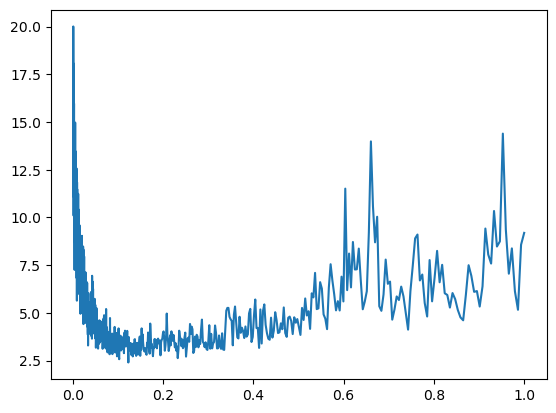

In [ ]:
plot.plot(lri, lossi)

Lets plot the exponent of the learning rate

[<matplotlib.lines.Line2D object at 0x7f995a478390>]

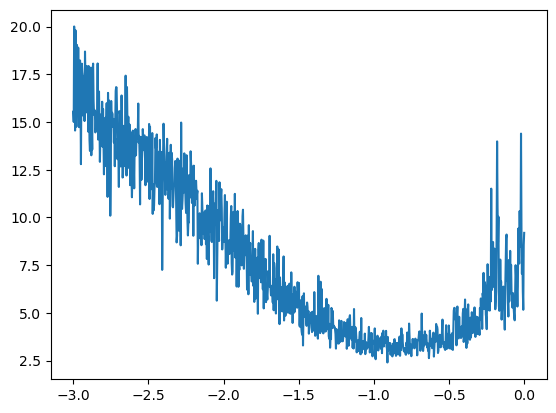

In [ ]:
plot.plot(lres, lossi)

In [ ]:
params, loss = train(10_000, X, Y, enable_print=False, lr=0.1)

In [ ]:
loss

2.8730247020721436

In [ ]:
evaluate_loss(params, X, Y)

tensor(2.5346, grad_fn=<NllLossBackward0>)

### Learning rate decay

In [ ]:
params, loss = train(10_000, X, Y, enable_print=False, lr=0.1)

In [ ]:
evaluate_loss(params, X, Y)

tensor(2.4748, grad_fn=<NllLossBackward0>)

In [ ]:
params, loss = train(10_000, X, Y, parameters = params, enable_print=False, lr=0.01)

In [ ]:
evaluate_loss(params, X, Y)

tensor(2.3843, grad_fn=<NllLossBackward0>)

In [ ]:
params, loss = train(10_000, X, Y, parameters = params, enable_print=False, lr=0.001)

In [ ]:
evaluate_loss(params, X, Y)

tensor(2.3754, grad_fn=<NllLossBackward0>)

## Train, Dev/Valid & Test Set

Training Split: 80% 
> Optimize the parameters of the model 


Validation Split: 10%
> Development over the hyperparameters of the model

Test Split: 10%
> Evaluate the performance of the model at the end

In [ ]:
def generate_train_valid_test_split(words):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8*len(words))
    n2 = int(0.9*len(words))

    Xtr, Ytr = generate_training_set(words[:n1], 3)
    Xdev, Ydev = generate_training_set(words[n1:n2], 3)
    Xte, Yte = generate_training_set(words[n2:], 3)
    
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [ ]:
Xtr, Ytr, Xdev, Ydev, Xte, Yte = generate_train_valid_test_split(words)

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
Xdev.shape, Ydev.shape

(torch.Size([22655, 3]), torch.Size([22655]))

In [ ]:
Xte.shape, Yte.shape

(torch.Size([22866, 3]), torch.Size([22866]))

In [ ]:
params, loss = train(30_000, Xtr, Ytr, enable_print=False)

In [ ]:
loss

2.5267984867095947

In [ ]:
params, loss = train(10_000, Xtr, Ytr, lr=0.01, parameters=params, enable_print=False)

In [ ]:
loss

2.570688247680664

In [ ]:
evaluate_loss(params, Xtr, Ytr)

tensor(2.3291, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(params, Xdev, Ydev)

tensor(2.3266, grad_fn=<NllLossBackward0>)

## Experiment: Larger Hidden Layer

In [ ]:
def track_hidden_layer_vs_loss(epochs, X, Y, parameters = [], lr=0.1, enable_print=True):
    if not parameters: parameters = initialize_params(300)
    
    for p in parameters: p.requires_grad = True 
    
    stepi = []
    lossi = []
    
    for i in range(epochs):
        loss = an_epoch_minibatch(parameters, X, Y, lr=lr)
        if enable_print: print(loss.item())
        
        stepi.append(i)
        lossi.append(loss.item())
        
    return parameters, stepi, lossi

In [ ]:
params, steps, losses = track_hidden_layer_vs_loss(30_000, Xtr, Ytr, lr=0.5, enable_print=False)

[<matplotlib.lines.Line2D object at 0x7f997f749710>]

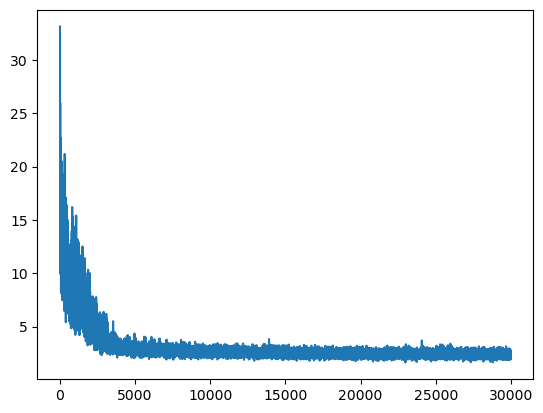

In [ ]:
plot.plot(steps, losses)

In [ ]:
evaluate_loss(params, Xtr, Ytr)

tensor(2.4145, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(params, Xdev, Ydev)

tensor(2.4132, grad_fn=<NllLossBackward0>)

In [ ]:
params, steps, losses = track_hidden_layer_vs_loss(30_000, X, Y, params, lr=0.1, enable_print=False)

In [ ]:
evaluate_loss(params, Xtr, Ytr)

tensor(2.2973, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(params, Xdev, Ydev)

tensor(2.2926, grad_fn=<NllLossBackward0>)

In [ ]:
params, steps, losses = track_hidden_layer_vs_loss(30_000, X, Y, params, lr=0.05, enable_print=False)

In [ ]:
evaluate_loss(params, Xtr, Ytr)

tensor(2.2798, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(params, Xdev, Ydev)

tensor(2.2770, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(params, Xte, Yte)

tensor(2.2773, grad_fn=<NllLossBackward0>)

## Visualize Character Embeddings

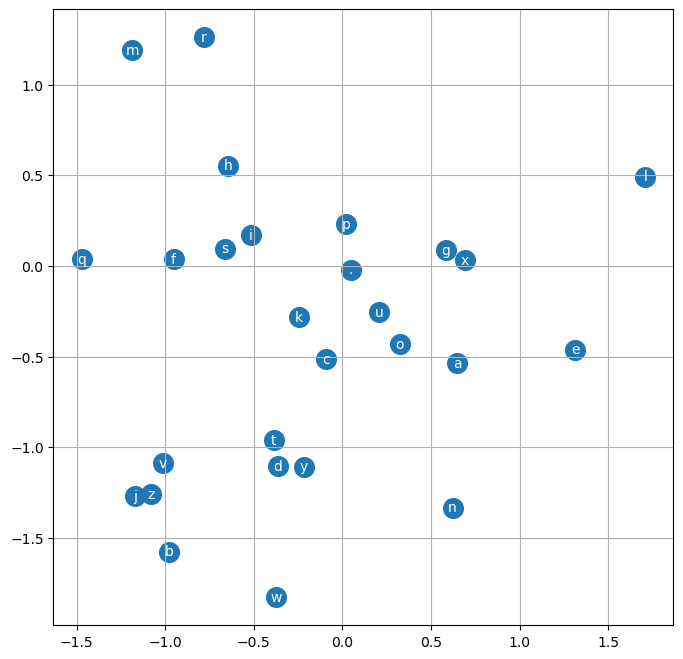

In [ ]:
plot.figure(figsize=(8,8))
plot.scatter(C[:, 0], C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plot.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plot.grid('minor')

## Larger Embedding Size

In [ ]:
def initialize_params(hc):
    C = torch.randn((27, 10), generator=g)
    W1 = torch.randn((30, hc), generator=g)
    b1 = torch.randn(hc, generator=g)
    W2 = torch.randn((hc, 27), generator=g)
    b2 = torch.randn(27, generator=g)

    return [C, W1, b1, W2, b2]

In [ ]:
def forward_pass(params, X):
    C, W1, b1, W2, b2 = params
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    return logits

In [ ]:
def track_hidden_layer_vs_loss(epochs, X, Y, parameters = [], lr=0.1, enable_print=True):
    if not parameters: parameters = initialize_params(200)
    
    for p in parameters: p.requires_grad = True 
    
    stepi = []
    lossi = []
    
    for i in range(epochs):
        loss = an_epoch_minibatch(parameters, X, Y, lr=lr)
        if enable_print: print(loss.item())
        
        stepi.append(i)
        lossi.append(loss.log10().item())
        
    return parameters, stepi, lossi

In [ ]:
params, steps, losses = track_hidden_layer_vs_loss(50_000, Xtr, Ytr, enable_print=False)

[<matplotlib.lines.Line2D object at 0x7f993b493cd0>]

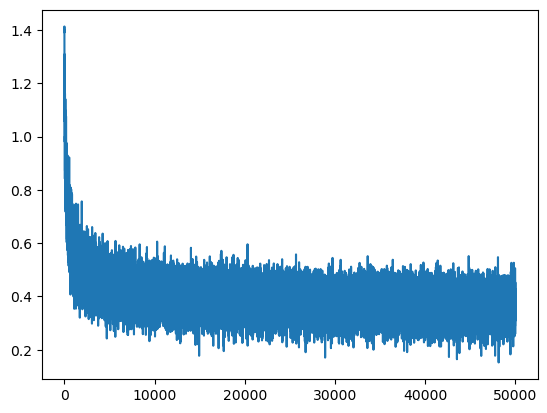

In [ ]:
plot.plot(steps, losses)

In [ ]:
evaluate_loss(params, Xtr, Ytr)

tensor(2.3460, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(params, Xdev, Ydev)

tensor(2.3639, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(params, Xte, Yte)

tensor(2.3736, grad_fn=<NllLossBackward0>)

In [ ]:
params, steps, losses = track_hidden_layer_vs_loss(50_000, Xtr, Ytr, params, lr=0.001, enable_print=False)

[<matplotlib.lines.Line2D object at 0x7f984ac705d0>]

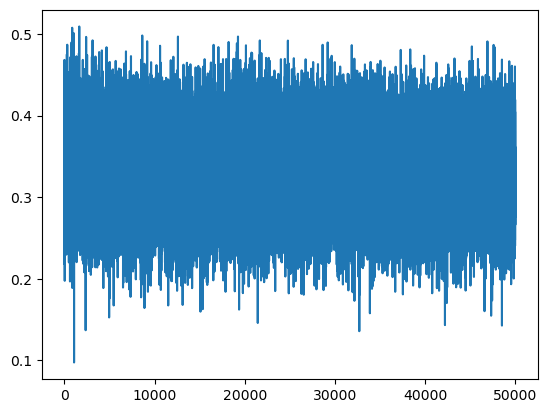

In [ ]:
plot.plot(steps, losses)

In [ ]:
evaluate_loss(params, Xtr, Ytr)

tensor(2.1660, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(params, Xdev, Ydev)

tensor(2.1936, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(params, Xte, Yte)

tensor(2.1990, grad_fn=<NllLossBackward0>)

## Sampling from the model

In [ ]:
def generate_words(count):
    for _ in range(count):
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
            logits = forward_pass(params, torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0: break

        print(''.join(itos[i] for i in out))

In [ ]:
generate_words(20)

namileina.

brigan.

marxea.

luel.

parkonzayah.

nwayleah.

jusi.

tyrfen.

win.

dylynn.

xolle.

dilin.

micheshevpaveett.

parandee.

yannie.

addioktes.

kajaurvne.

kah.

hari.

tor.